In [1]:
!pip install scikit-learn
!pip install torchvision

In [1]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report,accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV,cross_validate,train_test_split
import matplotlib.pyplot as plt

In [2]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              transforms.Lambda(lambda x: torch.flatten(x))])

train_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=True, download=True,
                             transform=transformer)

test_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=False, download=True,
                             transform=transformer)

batch_size_train= len(train_set)
batch_size_test=len(test_set)

In [3]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [4]:
def evaluate_models(models):
    results_short = {}
    for score in scores:
        print('='*40)
        print("# Tuning hyper-parameters for %s" % score)
        print()

        for m in model_lbls:
            print('-'*40)
            print("Trying model {}".format(models[m]['name']))
            clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=5,
                               scoring='%s_macro' % score, 
                               return_train_score = False,
                               n_jobs = -1, 
                               )
            clf.fit(train_x, train_y)
            print_results(clf)
            results_short[m] = clf.best_score_
        print("Summary of results for {}".format(score))
        print("Estimator")
        for m in results_short.keys():
            print("{}\t - score: {:4.2}%".format(models[m]['name'], results_short[m]))

def print_results(model):
    print("Best parameters set found on train set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    true_y, pred_y = test_y, model.predict(test_x)
    print(classification_report(true_y, pred_y))
    print()
    
def plot_scores_by_parameter(model,ks,X_train,X_test,y_train,y_test,visualize=True):
    train_scores = []
    test_scores = []
    
    for k in ks:
        clf = model(k).fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    if visualize:
        plt.figure(figsize=(10, 6))
        plt.plot(ks, train_scores, color='blue', label='train score')
        plt.plot(ks, test_scores, color='green', label='test score')
        plt.legend()
    return train_scores,test_scores

## KNN

In [5]:
from sklearn.neighbors import KNeighborsClassifier

KNN is simple machine learning algorithm. It classifies the test data based on the classes of the closest train entries.
The main hyper parameter for tuning the algorithm is K - the number of the train entries that will be used for classifying the new data.

Testing knn for different k

In [6]:
models = {
    'knn': {'name': '',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': [i+1 for i in range(15)],}]
          },
}

model_lbls = ['knn']
scores = ['precision']

evaluate_models(models)

# Tuning hyper-parameters for precision

----------------------------------------
Trying model 
Best parameters set found on train set:

{'n_neighbors': 6}

Grid scores on train set:


Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1000
           1       0.99      0.97      0.98      1000
           2       0.71      0.83      0.77      1000
           3       0.90      0.86      0.88      1000
           4       0.80      0.75      0.77      1000
           5       0.99      0.83      0.91      1000
           6       0.67      0.56      0.61      1000
           7       0.88      0.97      0.92      1000
           8       0.97      0.95      0.96      1000
           9       0.91      0.96      0.93      1000

    accuracy                           0.85     10000
   macro avg  

We get around 86% precission for 6 neighbours. Because KNN is the simplest algorithm this will be the baseline accuracy which we will try to improve.

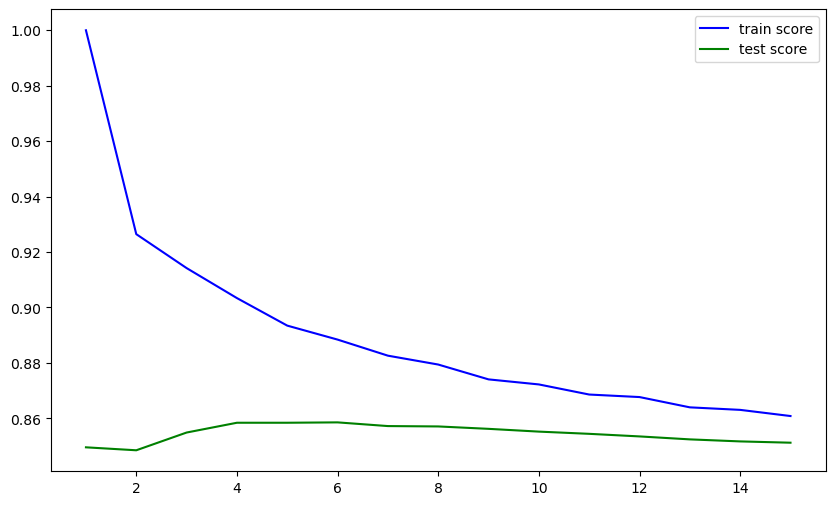

In [8]:
knn_constructor = lambda k: KNeighborsClassifier(n_neighbors=k)
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, random_state=0)

_=plot_scores_by_parameter(knn_constructor,[i+1 for i in range(15)],X_train,X_valid,y_train,y_valid)

The graph shows that with low k, we overfit the train data and with high we underfit. The elbow method suggests that we use 4.
The highest accuracy score on the test data is observed for k = 5.